In [1]:
from zoish.feature_selectors.randomshap import RandomizedSearchCVShapFeatureSelector
import logging
from sklearn.model_selection import KFold,train_test_split
import pandas as pd
from sklearn.pipeline import Pipeline
from feature_engine.imputation import (
    CategoricalImputer,
    MeanMedianImputer
    )
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score)
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


<Figure size 432x288 with 0 Axes>

# Example 1 : Use Adult Data Set (a classification problem)
  
https://archive.ics.uci.edu/ml/datasets/Adult

In [2]:
urldata= "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
# column names
col_names=["age", "workclass", "fnlwgt" , "education" ,"education-num",
"marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week",
"native-country","label"
]
# read data
data = pd.read_csv(urldata,header=None,names=col_names,sep=',')
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Define labels


In [3]:
data.loc[data['label']=='<=50K','label']=0
data.loc[data['label']==' <=50K','label']=0

data.loc[data['label']=='>50K','label']=1
data.loc[data['label']==' >50K','label']=1

data['label']=data['label'].astype(int)

# Train test split

In [4]:
X = data.loc[:, data.columns != "label"]
y = data.loc[:, data.columns == "label"]


X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.33, stratify=y['label'], random_state=42)


# Find feature types for later use

In [5]:
int_cols =  X_train.select_dtypes(include=['int']).columns.tolist()
float_cols =  X_train.select_dtypes(include=['float']).columns.tolist()
cat_cols =  X_train.select_dtypes(include=['object']).columns.tolist()


# Define Feature selector and set it argumens 

In [6]:
from zoish.utils.helper_funcs import RandomForestClassifier


grid_classification_xgb = RandomizedSearchCVShapFeatureSelector(
        # general argument setting        
        verbose=5,
        random_state=0,
        logging_basicConfig = None,
        # general argument setting        
        n_features=4,
        list_of_obligatory_features_that_must_be_in_model=[],
        list_of_features_to_drop_before_any_selection=[],
        # shap argument setting        
        estimator=RandomForestClassifier(),
        estimator_params={
        "max_depth": [4, 5],
        "n_estimators": [50, 100],
        },
        # shap arguments
        model_output="raw", 
        feature_perturbation="interventional", 
        algorithm="auto", 
        shap_n_jobs=-1, 
        memory_tolerance=-1, 
        feature_names=None, 
        approximate=False, 
        shortcut=False, 
        plot_shap_summary=True,
        save_shap_summary_plot=False,
        path_to_save_plot = './summary_plot.png',
        shap_fig = plt.figure(),
        n_iter = 10,
        ## optuna params
        performance_metric = 'f1',
        cv = StratifiedKFold(n_splits=3, shuffle=True),

)


root - INFO - Setting value for logging_basicConfig
root - INFO - Setting value for verbose
root - INFO - Setting value for xgbse_focus
root - INFO - Setting value for random_state
root - INFO - Setting value for n_features
root - INFO - Setting value for list_of_obligatory_features_that_must_be_in_model
root - INFO - Setting value for list of features to drop before any selection
root - INFO - Setting value for estimator
root - INFO - Getting value for estimator
root - INFO - RandomForestClassifier()
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Setting value for

<Figure size 432x288 with 0 Axes>

# Build sklearn Pipeline

In [7]:


pipeline =Pipeline([
            # int missing values imputers
            ('intimputer', MeanMedianImputer(
                imputation_method='median', variables=int_cols)),
            # category missing values imputers
            ('catimputer', CategoricalImputer(variables=cat_cols)),
            #
            ('catencoder', OrdinalEncoder()),
            # feature selection
            ('SFC_XGBCLS_OPTUNA', grid_classification_xgb),
            # classification model
            ('logistic', LogisticRegression())


 ])



# Run Pipeline

root - INFO - Getting value for estimator
root - INFO - Getting value for estimator_params
root - INFO - Getting value for performance metric
root - INFO - Getting value for verbose
root - INFO - Getting value for random_search_n_jobs
root - INFO - Getting value for n_iter
root - INFO - Getting value for cv
root - INFO - Getting value for xgbse_focus
The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END ......max_depth=4, n_estimators=50;, score=0.617 total time=   0.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/3] END ......max_depth=4, n_estimators=50;, score=0.585 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/3] END ......max_depth=4, n_estimators=50;, score=0.615 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/3] END .....max_depth=4, n_estimators=100;, score=0.618 total time=   0.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/3] END .....max_depth=4, n_estimators=100;, score=0.598 total time=   0.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/3] END .....max_depth=4, n_estimators=100;, score=0.619 total time=   0.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/3] END ......max_depth=5, n_estimators=50;, score=0.623 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/3] END ......max_depth=5, n_estimators=50;, score=0.622 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/3] END ......max_depth=5, n_estimators=50;, score=0.624 total time=   0.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/3] END .....max_depth=5, n_estimators=100;, score=0.627 total time=   0.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/3] END .....max_depth=5, n_estimators=100;, score=0.615 total time=   0.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/3] END .....max_depth=5, n_estimators=100;, score=0.626 total time=   0.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
root - INFO - Setting value for best estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for best estimator
root - INFO - Getting value for model_output
root - INFO - Getting value for feature perturbation
root - INFO - Getting value for algorithm
root - INFO - Getting value for shap_n_jobs
root - INFO - Getting value for memory_tolerance
root - INFO - Getting value for feature_names
root - INFO - Getting value for approximate
root - INFO - Getting value for shortcut


RandomForestClassifier


root - INFO - Getting value for plot shap summary
root - INFO - Getting value for n_features


.values =
array([[[ 5.24586221e-02, -5.24586221e-02],
        [ 8.60439248e-04, -8.60439248e-04],
        [ 2.58399164e-04, -2.58399164e-04],
        ...,
        [ 2.43836542e-03, -2.43836542e-03],
        [ 2.16477174e-02, -2.16477174e-02],
        [-1.83443953e-04,  1.83443953e-04]],

       [[ 3.38829822e-02, -3.38829822e-02],
        [ 1.02640560e-03, -1.02640560e-03],
        [-1.80762703e-05,  1.80762703e-05],
        ...,
        [ 2.05928037e-03, -2.05928037e-03],
        [ 1.42585697e-02, -1.42585697e-02],
        [-1.34378040e-04,  1.34378040e-04]],

       [[-1.81529451e-02,  1.81529451e-02],
        [ 9.81743987e-04, -9.81743987e-04],
        [ 3.50715842e-05, -3.50715842e-05],
        ...,
        [ 2.22275768e-03, -2.22275768e-03],
        [ 1.41430660e-02, -1.41430660e-02],
        [-1.52845867e-04,  1.52845867e-04]],

       ...,

       [[-3.03478917e-02,  3.03478917e-02],
        [ 2.47065193e-03, -2.47065193e-03],
        [-2.55516699e-04,  2.55516699e-04],
        

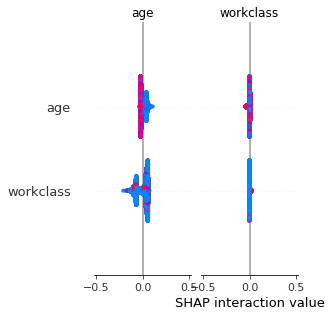

root - INFO - Getting value for save_shap_summary_plot
root - INFO - Setting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Setting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for n_features
root - INFO - Getting value for n_features
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df


                 0                                               1
0              age      [0.02696990826172884, 0.02696990826172884]
1        workclass   [0.0028854981686838913, 0.002885498168683891]
2           fnlwgt  [0.00038787844511668784, 0.000387878445116688]
3        education    [0.007742444244815358, 0.007742444244815361]
4    education-num      [0.04853080056947056, 0.04853080056947057]
5   marital-status      [0.06984045880728251, 0.06984045880728251]
6       occupation    [0.024124529349773206, 0.024124529349773206]
7     relationship      [0.06520940033290186, 0.06520940033290186]
8             race  [0.0005090910090958333, 0.0005090910090958343]
9              sex     [0.013860345337230068, 0.01386034533723007]
10    capital-gain    [0.034888733297694756, 0.034888733297694756]
11    capital-loss    [0.005532861195800647, 0.005532861195800647]
12  hours-per-week      [0.02916098642047549, 0.02916098642047549]
13  native-country  [0.0007765640185615981, 0.0007765640185615

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [8]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)


# Check performance of the Pipeline

In [9]:
print('F1 score : ')
print(f1_score(y_test,y_pred))
print('Classification report : ')
print(classification_report(y_test,y_pred))
print('Confusion matrix : ')
print(confusion_matrix(y_test,y_pred))


F1 score : 
0.6165445928479104
Classification report : 
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      8158
           1       0.70      0.55      0.62      2588

    accuracy                           0.83     10746
   macro avg       0.78      0.74      0.76     10746
weighted avg       0.83      0.83      0.83     10746

Confusion matrix : 
[[7535  623]
 [1157 1431]]
